# Procesamiento del Lenguaje Natural - Análisis de Sentimientos en Amazon

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
import string
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Fernando\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



### Fase 1: Exploración Inicial de los Datos

In [51]:
df = pd.read_csv('C:/Users/Fernando/Desktop/ESTUDIOS/Tony/amazon_alexa.csv',sep=",")
print(df.isnull().sum())
print(df.applymap(lambda x: isinstance(x, str) and x.isspace()).sum())
# Clearning nulls and white spaces
df = df[~df.applymap(lambda x: isinstance(x, str) and x.isspace()).any(axis=1)]
df = df.dropna()
print(df.info())


rating              0
date                0
variation           0
verified_reviews    1
dtype: int64
rating               0
date                 0
variation            0
verified_reviews    79
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 3070 entries, 0 to 3149
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3070 non-null   int64 
 1   date              3070 non-null   object
 2   variation         3070 non-null   object
 3   verified_reviews  3070 non-null   object
dtypes: int64(1), object(3)
memory usage: 119.9+ KB
None


##### Tenemos varios campos invalidos por espacios en blanco y 1 null, los borramos

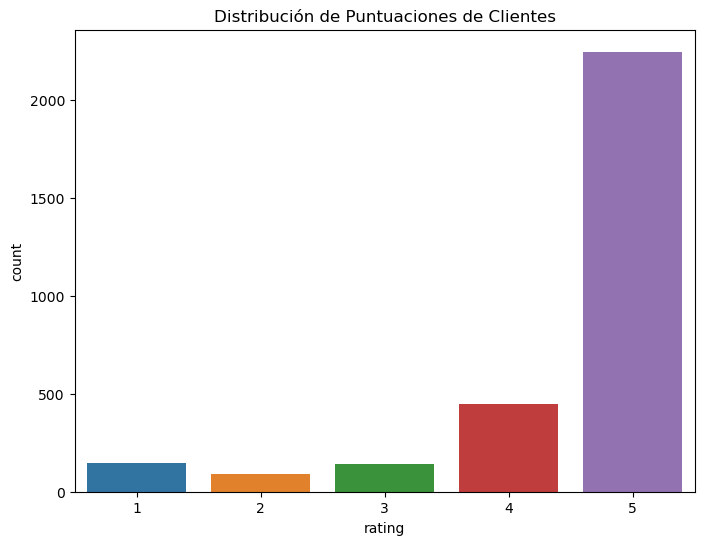

In [52]:
plt.figure(figsize=(8, 6))
sns.countplot(x='rating', data=df)
plt.title('Distribución de Puntuaciones de Clientes')   
plt.show()


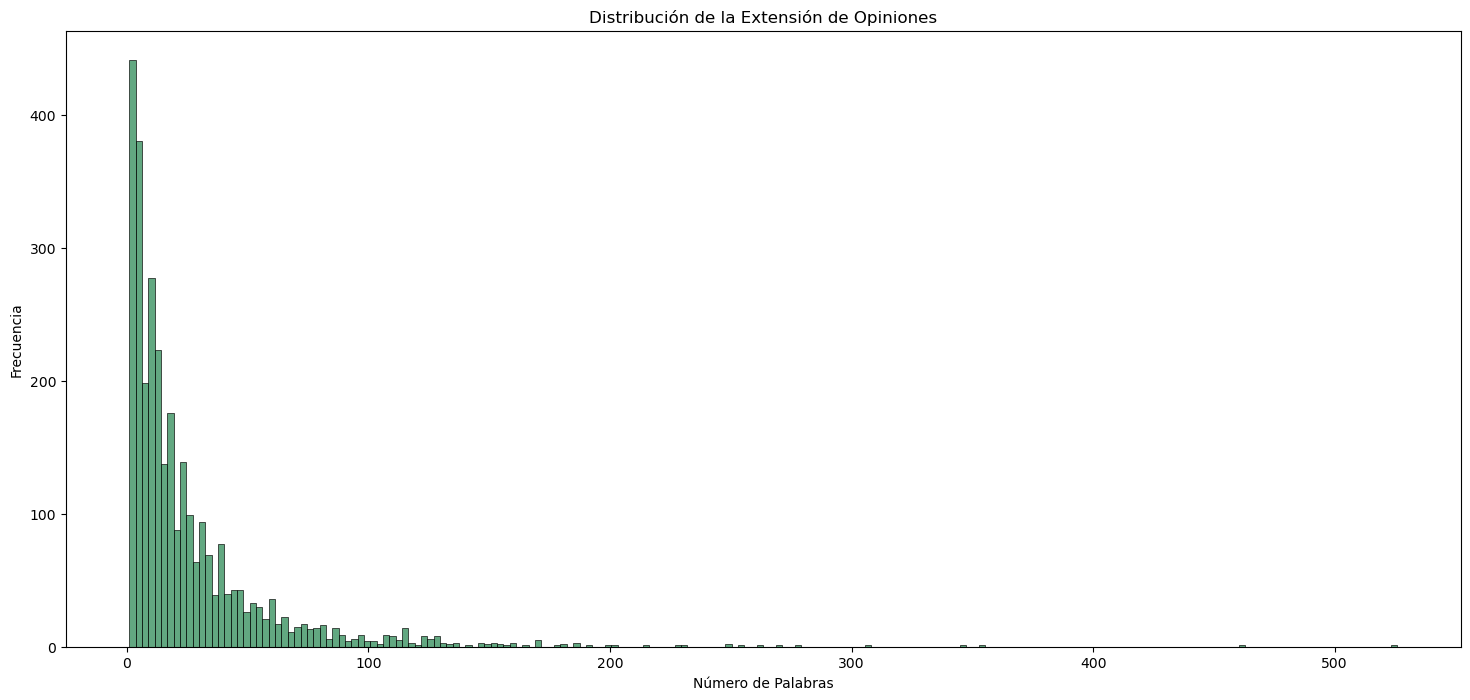

In [53]:
df['length'] = df['verified_reviews'].apply(lambda x: len(x.split()))

plt.figure(figsize=(18, 8))
sns.histplot(df['length'], bins=200, color="#2E8B57")
plt.title('Distribución de la Extensión de Opiniones')
plt.xlabel('Número de Palabras')
plt.ylabel('Frecuencia')
plt.show()

In [54]:
media_palabras = df['length'].mean()
print("Media:",media_palabras)

opiniones_cercanas_media = df[(df['length'] >= media_palabras - .1) & (df['length'] <= media_palabras + .1)]['verified_reviews']

print("Opiniones cercanas a la media de palabras:")
for i, opinion in enumerate(opiniones_cercanas_media[:5]):
    print(f"{i + 1}. {opinion}")


Media: 25.951791530944625
Opiniones cercanas a la media de palabras:
1. Fun item to play with and get used to using.  Sometimes has hard time answering the questions you ask, but I think it will be better.
2. Very satisfied with the Echo. Alexa now controls the lights in my family room and my wife can listen to Jimmy Buffet by just asking Alexa.
3. The echo doesn’t come with a built in battery so it has to be plugged in at all times to use it, makes it quite inconvenient.
4. Easy setup using the app, which was also easy to install on my phone.  The sound quality while for listening to music on Pandora is wonderful!!
5. Love it even though I’m still trying to figure out all the other things I can do with this item it works great with my phone.


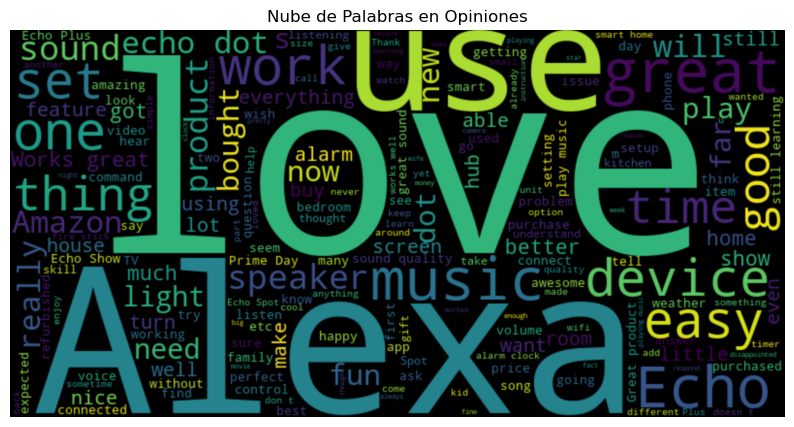

In [55]:
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(' '.join(df['verified_reviews']))

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bicubic')
plt.axis('off')
plt.title('Nube de Palabras en Opiniones')
plt.show()

### Fase 2: Preprocesado del Texto

In [56]:
def preprocess_text(text):
    text = ''.join([char for char in text if char not in string.punctuation])
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word.lower() not in stop_words])
    return text

df['clean_reviews'] = df['verified_reviews'].apply(preprocess_text)

df['clean_reviews'][:5]

0                                            Love Echo
1                                                Loved
2    Sometimes playing game answer question correct...
3    lot fun thing 4 yr old learns dinosaurs contro...
4                                                Music
Name: clean_reviews, dtype: object

### Fase 3: Paso previo a la preparación del modelo

In [57]:
df['feedback'] = df['rating'].apply(lambda x: 1 if x >= 3 else 0)

### Fase 4: Creación y análisis de resultados de un modelo Naive Bayes

In [58]:
X_train, X_test, y_train, y_test = train_test_split(df['clean_reviews'], df['feedback'], test_size=.2, random_state=8)

vectorizer = CountVectorizer(token_pattern=r'\b\w+\b') # Acepta tambien letras sueltas

X_train_vec = vectorizer.fit_transform(X_train)
naive_bayes_model = MultinomialNB()
naive_bayes_model.fit(X_train_vec, y_train)

X_test_vec = vectorizer.transform(X_test)
predictions = naive_bayes_model.predict(X_test_vec)

conf_matrix = confusion_matrix(y_test, predictions)
print("Matriz de Confusión:")
print(conf_matrix)
print(f"Verdaderos Negativos (TN): {conf_matrix[0, 0]}")
print(f"Falsos Positivos (FP): {conf_matrix[0, 1]}")
print(f"Falsos Negativos (FN): {conf_matrix[1, 0]}")
print(f"Verdaderos Positivos (TP): {conf_matrix[1, 1]}")

classification_rep = classification_report(y_test, predictions)
print("\nInforme de Clasificación:")
print(classification_rep)


Matriz de Confusión:
[[ 15  40]
 [  2 557]]
Verdaderos Negativos (TN): 15
Falsos Positivos (FP): 40
Falsos Negativos (FN): 2
Verdaderos Positivos (TP): 557

Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.88      0.27      0.42        55
           1       0.93      1.00      0.96       559

    accuracy                           0.93       614
   macro avg       0.91      0.63      0.69       614
weighted avg       0.93      0.93      0.91       614



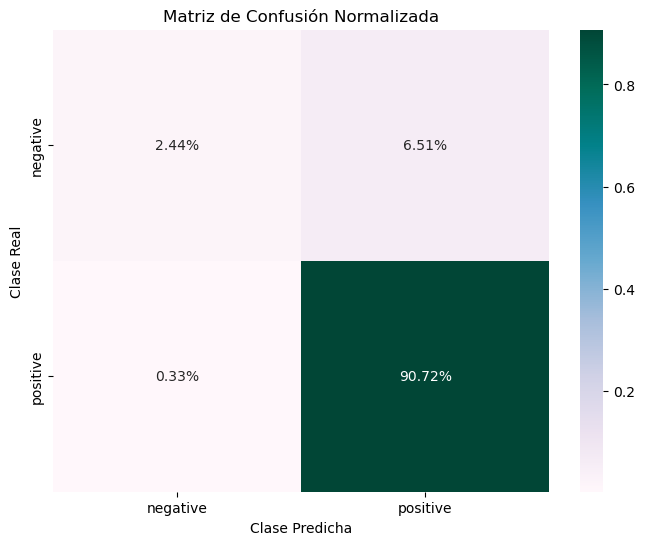

In [59]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True, fmt='.2%', cmap='PuBuGn', yticklabels=["negative", "positive"], xticklabels=["negative", "positive"])
plt.title("Matriz de Confusión Normalizada")
plt.xlabel("Clase Predicha")
plt.ylabel("Clase Real")
plt.show()

#### ¿Qué podemos decir sobre la fiabilidad de la predicción del modelo?

En este caso podriamos decir que el modelo es muy fiable con los casos de verdaderos positivos, es decir puede llegar a predecir correctamente opiniones positivas, pero tiene un problema con las opiniones negativas ya que podemos ver que tiene un 0.27 en recall en ese caso, eso significa que etiqueta incorrectamente opiniones negativas como positivas. Por lo tanto quizas tendriamos que optar por añadir algun parametro extra para que el modelo sea mejor.

#### ¿Qué similitudes y diferencias comparte el planteamiento, desarrollo y resolución de este caso aplicando Naïve Bayes con respecto a los dos casos tratados en clase (es decir, de las prácticas relativas al analizador de SPAM, por un lado, y la identificación de remitente anónimo de una carta, por otro)?


Realmente los 3 son parecidos, ya que se aplica el teorema de Naive Bayes.
Hay que mirar los datos iniciales, luego limpiar nulos, blancos faltas de ortografia etc...
En si lo que creo que es diferente es que hemos usado el clasificador de MultinomialNB para este caso de opiniones de amazon, ya que como se realiza con las frecuencia de las palabras es el mejor que se puede usar en este caso.

Luego en el de spam se podria usar otro clasificador como puede el de BernoulliNB ya que sirve para clasificar tipos de datos binarios es decir en nuestro caso para clasificar si es o no es spam segun la existencia o no existencia de ciertas palabras, aunque eso ya depende mas del enfoque que se quiera, si queremos mas falsos positivos o menos.